### About   
This notebook aims to generate a random binary classification dataset, conduct exploratory data analysis, train an SVM classifier, an XGBoost classifier, and evaluate the results using a ROC curve and other evaluation metrics. Subsequently, feature selection techniques will be applied, and the SVM model will be re-evaluated after feature selection. The results will be compared with the original SVM model. Additionally, potential feature selection bias will be examined. Next, the two models will be comapred with two additional models provided directly from Moodle. The presence of overfitting, underfitting, and the identification of the best model will also be explored. Lastly, label leakage will be investigated.

In [256]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, classification_report
from joblib import dump

import xgboost as xgb

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

from joblib import load

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings # Ignore warnings to keep notebook clean
warnings.filterwarnings("ignore")

### Task 1: Simulate a data set, and split it

**Q: Can you explain what does 'make_classification' produce?**

It generates a random binary classification dataset (we are simulating the data) with 500 samples, 300 features and 2 informative features.
- The n_samples parameter is the number of samples, 
- n_features is the number of total features
- n_informative is the number of informative features, these features are more helpful in predicting the target classes.
- n_redundant is the number of redundant features, these features are linear combinations of the informative features.
- n_classes is the number of classes/labels (In this case there are 2 classes, 0 and 1)

In [257]:
rand_state = 12 # Setting random state for reproducibility

np.random.seed(rand_state)

# Generating a random dataset
X, y = make_classification(n_samples=500, n_features=300, n_informative=2, n_redundant=0, n_classes=2, random_state=rand_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state) # Splitting the data into train and test sets, 20% test size and 80% train size

In [258]:
X_df = pd.DataFrame(X) # Convert the features into a dataframe
y_df = pd.DataFrame(y) # Convert the target variable into a dataframe

df = pd.concat([X_df, y_df], axis=1) # Joining the features and target variable into a single dataframe

In [259]:
# Checking for missing values
missing_values = df.isnull().sum().sum()
print(f"Missing values: {missing_values}")

Missing values: 0


In [260]:
df.describe() # Displaying the summary statistics of the dataset

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,0
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.011506,-0.075646,0.032460,0.076822,-0.080760,0.040815,-0.007810,-0.044213,-0.075609,-0.044127,...,0.057732,-0.033898,0.020211,0.020869,-0.001453,-0.042336,0.054601,-0.000064,0.009652,0.506000
std,1.062078,0.976914,1.040127,0.990473,1.035699,0.967365,0.946493,0.963267,1.003241,0.964103,...,0.982039,1.010821,0.958150,1.010527,1.009324,0.984734,0.974868,0.975638,0.967160,0.500465
min,-3.265735,-2.716537,-2.824305,-2.616852,-3.126662,-3.489603,-2.596471,-2.486705,-4.093377,-2.591649,...,-3.019964,-3.678353,-2.406524,-2.645694,-3.485083,-3.593522,-2.946415,-3.541275,-2.864379,0.000000
25%,-0.615773,-0.725617,-0.629073,-0.568272,-0.780220,-0.593273,-0.661115,-0.696414,-0.803381,-0.708829,...,-0.590468,-0.673585,-0.595047,-0.651549,-0.704252,-0.697115,-0.559382,-0.703659,-0.606319,0.000000
50%,0.039379,-0.085723,0.078136,0.048769,-0.063540,0.004742,0.030972,-0.023100,-0.045158,0.004813,...,0.040231,-0.032850,0.005561,0.030440,0.049501,-0.000442,0.087252,0.013439,-0.003599,1.000000
75%,0.682359,0.610861,0.742029,0.722869,0.611601,0.734437,0.657812,0.563092,0.572137,0.588901,...,0.666207,0.663602,0.616955,0.667895,0.650737,0.637799,0.682445,0.633464,0.676344,1.000000
max,3.084265,3.215027,2.840325,3.810270,3.470177,3.832386,2.759100,2.605122,3.000636,2.886540,...,3.155315,2.601546,2.926902,3.497329,3.597031,3.340030,2.799566,2.642002,3.162538,1.000000


In [261]:
# Displaying the features with highest correlation with the target variable
print(df.corr().iloc[-1].sort_values(ascending=False).head(10))

0      1.000000
67     0.739717
62     0.116032
192    0.100261
165    0.099732
237    0.095035
219    0.093980
255    0.093839
266    0.086762
249    0.085389
Name: 0, dtype: float64


We can see the feature '67' is highly correlated with the target variables.

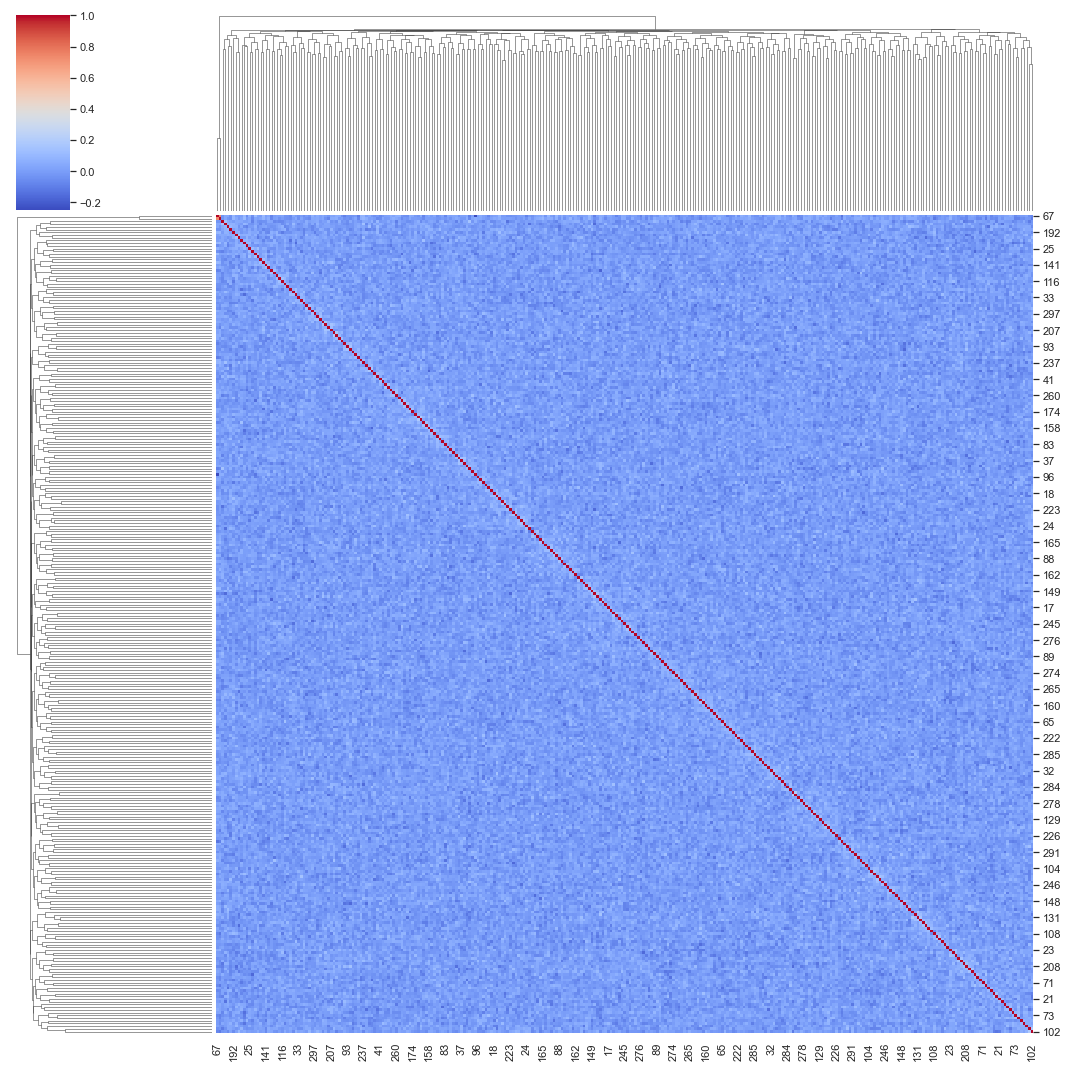

In [262]:
# Generating a heatmap of the correlation matrix with dendrogram
correlation_matrix = df.corr() # Calculating the correlation matrix
correlation_matrix = np.clip(correlation_matrix, -1, 1) # Clipping the correlation matrix to avoid NaN values
linkage = hierarchy.linkage(correlation_matrix, method='average') # Calculating the linkage matrix
g = sns.clustermap(correlation_matrix, row_linkage=linkage, col_linkage=linkage, cmap='coolwarm', annot=False, figsize=(15, 15))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # Rotating the y-axis labels of the heatmap
plt.show() # Display the heatmap

In [263]:
# Checking for class imbalance in the target variable
class_counts = df.iloc[:, -1].value_counts()
print(f"Class counts: ")
print(class_counts)

Class counts: 
1    253
0    247
Name: 0, dtype: int64


**Q: Describe X.**  

X is a numpy array representing a dataframe of feature columns. It consits of 300 features with 500 rows (instances/samples), with feature '67' having the highest correlation with the target columns (0.739717). There are 253 samples labeled '1' and 247 '0', so there is not a significant class imbalance. 

### Task 2: Train a SVM classifier

In [264]:
# Training a SVM classifier
classifier = SVC(kernel="linear",probability=True, random_state=rand_state) # Create a SVM classifier
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
dump(classifier, "SVM_classifier") # This line save the classifier into a file called ‘classifier’

['SVM_classifier']

In [265]:
# Plotting the confusion matrix of the SVM classifier
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
tn, fp, fn, tp = cm.ravel()
print("tn =", tn, ", fp =", fp, ", fn =", fn, ", tp =", tp)
print("-----------------")
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[41  8]
 [14 37]]
tn = 41 , fp = 8 , fn = 14 , tp = 37
-----------------
Sensitivity: 0.7254901960784313
Specificity: 0.8367346938775511


- True Negatives (TN): 41 instances were correctly predicted as class 0.  
- False Positives (FP): 8 instances were incorrectly predicted as class 1 when they were actually class 0.  
- False Negatives (FN): 14 instances were incorrectly predicted as class 0 when they were actually class 1.  
- True Positives (TP): 37 instances were correctly predicted as class 1.

In [266]:
# Printing Accuracy, Precision, Recall and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79        49
           1       0.82      0.73      0.77        51

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



**Q: Is this a reasonable classifier?**  

The SVM classifier shows reasonably balanced performance between the two classes, with slightly better precision for class '1' and better recall for class '0'. Additionally, the sensitivity of the classifier is 0.725, indicating that it correctly identifies 72.5% of the positive instances (class '1'). On the other hand, the specificity of the classifier is 0.837, suggesting that it accurately identifies 83.7% of the negative instances (class '0'). This essentially means the model does not heavily favor one class over the other.  With a decent accuracy of 78%, it is reasonably accurate. However, factors such as the lack of cross-validation should be taken into account, as it could have significantly affected the performance.

### Task 3: ROC curve

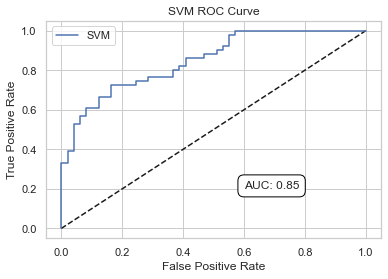

In [267]:
# Plotting a ROC curve for the SVM classifier
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.text(0.6, 0.2, f"AUC: {roc_auc_score(y_test, y_pred_prob):.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend()
plt.show()


**Question 1: In general, what does a ROC curve show?**  
The ROC curve represents the perfomance of a binary classification model. It shows the relation/trade-off between the sensitivity (true positive rate) and 1-specifity (false positive rate). Generally speaking, the closer the curve is to the top left corner, the better the perfomance. The Area under the ROC curve represents the overall perfomance.  

**Question 2: What can you say about the classifier based on the ROC curve?**  
In the SVM classifier trained above, the AUC value of 0.85 suggests that the classifier has a high ability to distinguish between the two classes. The curve is  above the diagonal line, which represents a random classifier. Therefore, this means that the classifier is making decisions that are significantly better than just random guessing. Lastly, the initial slope of the curve is quiet steep, which indictes that at a lower threshold, the classifier captures a large proportion of the true positives while incurring a relatively small proportion of false positives. Overall, considering the ROC curve and the AUC together, the classifier is performing decently well.

### Task 4: Try one or more ML models

We will be creating an XGBoost model for binary classification. XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm known for its effectiveness in handling tabular data and achieving high predictive accuracy.

In [268]:
# Creating a XGBoost classifier
model = xgb.XGBClassifier(random_state=rand_state, learning_rate=0.01) # Create a XGBoost model with a learning rate of 0.001.
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [269]:
#  Confusion matrix of the XGBoost classifier
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
tn, fp, fn, tp = cm.ravel()
print("tn =", tn, ", fp =", fp, ", fn =", fn, ", tp =", tp)
print("-----------------")
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[47  2]
 [ 6 45]]
tn = 47 , fp = 2 , fn = 6 , tp = 45
-----------------
Sensitivity: 0.8823529411764706
Specificity: 0.9591836734693877


- True Negatives (TN): 47 instances were correctly predicted as class 0.  
- False Positives (FP): 2 instances were incorrectly predicted as class 1 when they were actually class 0.  
- False Negatives (FN): 6 instances were incorrectly predicted as class 0 when they were actually class 1.  
- True Positives (TP): 45 instances were correctly predicted as class 1.

In [270]:
# Printing Accuracy, Precision, Recall and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        49
           1       0.96      0.88      0.92        51

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



The XGBoost classifier demonstrates excellent performance across multiple evaluation metrics. Its high sensitivity and specificity indicate its effectiveness in distinguishing between the two classes. The precision suggests that when the model predicts a class, it is likely to be correct. The F1-scores for both classes are identical and high, underscoring the model's balanced performance between precision and recall. The overall accuracy of 92% confirms the model's strong predictive capabilities. However, factors such as no cross-validation can significantly affect the performance of the classifier. 

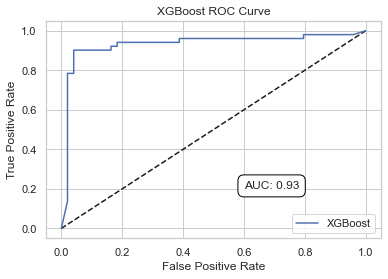

In [271]:
# Plotting a ROC curve for the XGBoost classifier
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.text(0.6, 0.2, f"AUC: {roc_auc_score(y_test, y_pred_prob):.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend()

Adding the ROC curve analysis to the initial performance report, we find that the XGBoost classifier not only shows high accuracy, sensitivity, specificity, precision, and F1-score but also has an excellent AUC of 0.93. The high AUC value verifies the previously noted performance metrics, confirming that the classifier has a high likelihood of correctly distinguishing between the two classes across various thresholds.

**Which model perform better?**  
The XGBoost classifier demonstrated excellent performance across multiple evaluation metrics, including high sensitivity, specificity, precision, and F1-score. It achieved an overall accuracy of 92% (While the SVM Classifier achieved an overall accuracy of 78%), indicating strong predictive capabilities. The balanced F1-scores for both classes further highlight the model's ability to maintain a good trade-off between precision and recall.

Moreover, the XGBoost classifier achieved an impressive AUC value of 0.93, indicating a high ability to distinguish between the two classes while the SVM classifier had an AUC of 0.85, which suggests that the XGBoost classifier outperforms the SVM classifier in terms of its ability to make accurate predictions.  

However, It is worth noting that both models lacked cross-validation, which could have influenced their performance. Overall the XGBoost classifier demonstrated much better performance compared to the SVM classifier.

*Note: I had intended to train a CatBoost classifier; however, due to the extensive workload of my COMP2119 "Data Structures and Algorithms" assignment, I was unable to do so.*

### Task 5: Feature selection Feature Selection

In [272]:
skb = SelectKBest(score_func = f_classif, k=50) # Selecting the 50 best features with the highest F-statistic

# Train and transform the dataset according to the SelectKBest
X_selected = skb.fit_transform(X, y)

# Splitting the data into train and test sets, 20% test size and 80% train size
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=rand_state)

print('Number of features after feature selection: {}'.format(X_train_selected.shape[1]))

Number of features after feature selection: 50


**Question: Find out what is f_classif, and explain how this approach can achieve the effect of feature selection?**

Essentially, ‘f_classif’ is a statistical method used for feature selection that relies on the ANOVA F-value between label/feature for classification tasks. The ANOVA (Analysis of Variance) F-value measures the degree of variance between different classes and the target variable ‘y’.

Next, we use ‘SelectKBest,’ which reduces the dimensionality of the dataset. This reduction can reduce overfitting by removing irrelevant and redundant features. In this case, we are selecting the 50 best features with the highest F-Statistics.

Overall, the use of f_classif with SelectKBest for feature selection effectively identifies and retains only those features that have the most significant relationship with the target variable ‘y’.

### Task 6: Evaluate after feature selection

In [273]:
# Train a SVM classifier
classifier_selected = SVC(kernel="linear",probability=True, random_state=rand_state) # Create a SVM classifier
classifier_selected.fit(X_train_selected, y_train_selected)

y_pred_selected = classifier_selected.predict(X_test_selected)

In [274]:
#Confusion matrix
cm = confusion_matrix(y_test_selected, y_pred_selected)
print("Confusion Matrix:")
print(cm)
tn, fp, fn, tp = cm.ravel()
print("tn =", tn, ", fp =", fp, ", fn =", fn, ", tp =", tp)
print("-----------------")
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[41  8]
 [ 6 45]]
tn = 41 , fp = 8 , fn = 6 , tp = 45
-----------------
Sensitivity: 0.8823529411764706
Specificity: 0.8367346938775511


In [275]:
# Printing Accuracy, Precision, Recall and F1 Score
print(classification_report(y_test_selected, y_pred_selected))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85        49
           1       0.85      0.88      0.87        51

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



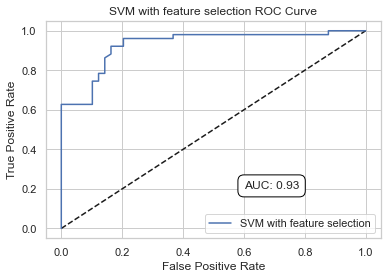

In [276]:
# Plotting a ROC curve for the SVM classifier with feature selection
y_pred_prob_selected = classifier_selected.predict_proba(X_test_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_selected, y_pred_prob_selected)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM with feature selection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM with feature selection ROC Curve')
plt.text(0.6, 0.2, f"AUC: {roc_auc_score(y_test_selected, y_pred_prob_selected):.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend()
plt.show()

**Q1. What are the new accuracy and AUROC estimates?**  
The new accuracy of the SVM is 86% and has a AUC score of 0.93  

**Q2. How do they compare to the original estimates?**  
Without feature selection, the accuracy of the SVM classifier is 78%. With feature selection, the accuracy improves to 86%. This indicates that after removing less important features, the model is better able to correctly classify new instances. The AUC without feature selection is 0.85 and with feature selection, the AUC score increases to 0.93. This improvement suggests that the model with feature selection is significantly better at distinguishing between the two classes across all thresholds, indicating a better and reliable classifier. There was a slight increase in precision (0.82 to 0.85) and a significiant increase in Recall (0.73 to 0.88). There is also a increase in Sensitivity from 0.725 to 0.882 but the Specificity remains the same for both models. This indicates that the ability of the model to correctly identify negative instances is unaffected by feature selection.

**Q3. Explain**  
The use of feature selection in training the SVM classifier has led to significant improvements in all key performance metrics, including accuracy, AUC, sensitivity, and F1-scores. This suggests that removing the irrelevant and redundant features can greatly enhance the effectiveness of a model, making it not only more accurate but also more capable of making correct predictions on unseen data.

### Task 7: Is there a feature selection bias?

In [277]:
skb = SelectKBest(score_func=f_classif, k=50)

X_train_s = skb.fit_transform(X_train, y_train)
X_test_s = skb.transform(X_test);

classifier_s = SVC(kernel="linear",probability=True, random_state=rand_state)
classifier_s.fit(X_train_s, y_train)

y_pred_s = classifier_s.predict(X_test_s)

cm_s = confusion_matrix(y_test, y_pred_s)
print("Confusion Matrix:")
print(cm_s)

accuracy_s = accuracy_score(y_test, y_pred_s)
print("Accuracy:", accuracy_s)

y_prob_s = classifier_s.predict_proba(X_test_s)[:, 1]
auroc_s = roc_auc_score(y_test, y_prob_s)
print("AUROC:", auroc_s)

Confusion Matrix:
[[40  9]
 [10 41]]
Accuracy: 0.81
AUROC: 0.8535414165666266


**Q: What are these new accuracy and AUROC estimates?** 
The Accuracy is 81% with a AUC of 0.85. 

**Q: How do they compare to the previous estimates?**  
There is a slight change in the accuracy of the 2 instances of the SVM classifier (with feature selection), the Accuracy dropped from 86% to 81% and the AUC score also fell from 0.93 to 0.85.

**Q: Is there a feature selection bias?**
Yes, there may be a potential feature selection bias in feature selection. In order to ensure a controlled environment, both SVM models are configured with identical parameters and a fixed 'random state'.

**Q: Explain what is feature selection bias in your own words.**  
Feature selection bias occurs when specific features are chosen for training a model, but they have an artificial relationship with the target variable and do not accurately represent the entire sample being studied. As a result, if this model is deployed in a real-world setting, it can introduce bias and provide incorrect results. When feature selection bias is present, the model's training process focuses on a limited set of features that may not capture the true complexity and diversity of the data. 

**Q:How may we get around this?**
Ensure the dataset is diverse and representative of the population you want to make predictions for. A better way is to use domain knowledge; someone who has expertise in the domain will be able to identify the more important features to incorporate (features that may statistically not seem highly correlated with the target in the training dataset). 

### Task 8: Compare ML models

In [278]:
# Load classifiers
SVM_classifier = load("SVM_classifier")
omega = load("omega")
upsilon = load("upsilon")

In [279]:
# Classfication report of each classifier
print("SVM_classifier")
print(classification_report(y_test, SVM_classifier.predict(X_test)))
print("omega")
print(classification_report(y_test, omega.predict(X_test)))
print("upsilon")
print(classification_report(y_test, upsilon.predict(X_test)))

SVM_classifier
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        49
           1       0.82      0.73      0.77        51

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

omega
              precision    recall  f1-score   support

           0       0.79      0.45      0.57        49
           1       0.62      0.88      0.73        51

    accuracy                           0.67       100
   macro avg       0.71      0.67      0.65       100
weighted avg       0.70      0.67      0.65       100

upsilon
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.51      1.00      0.68        51

    accuracy                           0.51       100
   macro avg       0.26      0.50      0.34       100
weighted avg       0.26      0.51      0.34  

- AUC Scores -
SVM_classifier: 0.849139655862345
omega: 0.7845138055222088
upsilon: 0.8347338935574229


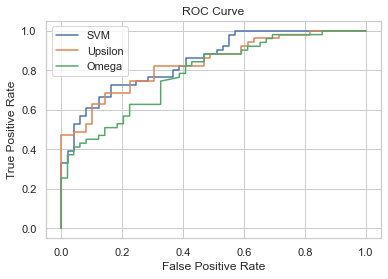

In [280]:
# Plotting the ROC curve of each classifier
fpr, tpr, thresholds = roc_curve(y_test, SVM_classifier.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='SVM')
fpr, tpr, thresholds = roc_curve(y_test, upsilon.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Upsilon')
fpr, tpr, thresholds = roc_curve(y_test, omega.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Omega')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

print("- AUC Scores -")
print("SVM_classifier:", roc_auc_score(y_test, SVM_classifier.predict_proba(X_test)[:,1]))
print("omega:", roc_auc_score(y_test, omega.predict_proba(X_test)[:,1]))
print("upsilon:", roc_auc_score(y_test, upsilon.predict_proba(X_test)[:,1]))

**Evaluate and compare the performance of the two provided classifiers: omega and upsilon.**  

Please discuss whether each classifier is:
- a good classifier  
- Likely suffering from overfitting  
- Likely suffering from underfitting  

The classifier "omega" a decent moderate performance across various metrics on a dataset. It achieves an accuracy of 67%. The precision, which measures the accuracy of positive predictions, is higher for class 1 (0.62) compared to class 0 (0.79), suggesting it is more reliable in predicting class 1 instances as positive. However, its recall, which assesses the classifier's ability to identify all positive instances, is significantly better for class 1 (0.88) than for class 0 (0.45), indicating it captures a higher proportion of actual class 1 instances. The AUC Score of 0.7845 suggests a decent ability to distinguish between the two classes. Overall, while the classifier performs reasonably well in distinguishing between the two classes it can be more accurate.  
  
The results for the classifier "upsilon" indicate a highly imbalanced performance between the two classes (0 and 1). It completely fails to predict class 0 correctly, with a precision, recall, and F1-score of 0.00, indicating it did not correctly identify any instances of class 0. In contrast, it achieves a precision of 0.51 for class 1, with a recall of 1.00, meaning it classified all instances as class 1, which explains the F1-score of 0.68 for class 1 due to its formula that considers both precision and recall. This results in an overall accuracy of 51%, which solely comes from correctly predicting class 1 instances. Despite the poor classification performance, the AUC score is  high at 0.8347, suggesting it can rank instances correctly if it were to distinguish between the classes.
It's challenging to directly conclude if the classifier is suffering from overfitting or underfitting from these metrics but seeing it has a recall of 1.00 for the label 1 it makes me think it has overfitted, as if it underfitted there might have been more instances where it failed to predict the label '1' correctly.

**Develop a procedure to test your hypothesis.**

In [281]:
# Checking if the upsilion classifier overfits or underfits the data by evaluating the performance on the training set
print("Training Set Performance")
print(classification_report(y_train, upsilon.predict(X_train)))

Training Set Performance
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.51      1.00      0.67       202

    accuracy                           0.51       400
   macro avg       0.25      0.50      0.34       400
weighted avg       0.26      0.51      0.34       400



After testing the model on the training dataset, it doesn't appear to be overfitted. If it were overfit, it would have performed better on the training dataset. Instead, there is a higher possibility that it is underfitted and/or there is a bias in the dataset on which it was trained. Perhaps there was a class imbalance in the training dataset, with much more or even only data for the '1' class. Additionally, there may have been a feature selection bias, where only features significantly related to the '1' class were chosen.

### Task 9: (Bonus) label leakage

**Can you identify one other form of label leakage?**  
Leakage through future date or time-based leakage happens when information that is directly related to the target label is included as a feature for training, but this data is generally not available at the time of prediction in a practical environment.

**Come up with one practical example**  
For instance, if you're predicting stock prices and your features include data points from the future (like future earnings reports or indicators derived from future events), the model will learn from this future information, leading to strong performance during training and validation but this model performance will significantly drop when used in the real world as the future data is not available.

In [285]:
# Simulating stock prices
n_days = 2000 
initial_price = 100
daily_returns = np.random.normal(0.001, 0.02, n_days)
prices = initial_price * np.cumprod(1 + daily_returns)

In [286]:
# Feature Engineering with Future Information
df = pd.DataFrame(prices, columns=['Price'])
df_no_future = df.copy()
df['Future_Avg'] = df['Price'].rolling(window=5).mean().shift(-5)  # uses future data
df.dropna(inplace=True)

X = df[['Future_Avg']] 
y = df['Price']
# Splitting the data into train and validation sets, 20% validation size and 80% train size
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rand_state)

model = LinearRegression() # Simple Linear Regression Model
model.fit(X_train, y_train)

y_pred = model.predict(X_val) # Making predictions on the validation set

mse = mean_squared_error(y_val, y_pred)
print(f'MSE on Validation Set: {mse}') # Calculating the Mean Squared Error on the validation set

MSE on Validation Set: 56.95367350652453


In [287]:
# Feature Engineering without Future Information
df = df_no_future.copy()

df['Past_Avg'] = df['Price'].shift(1).rolling(window=5).mean() # Using past data
df.dropna(inplace=True)

X = df[['Past_Avg']] 
y = df['Price']

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()  # Using a Linear Regression model
model.fit(X_train, y_train)  # Training the model

y_pred = model.predict(X_val)  # Making predictions on the validation set

mse = mean_squared_error(y_val, y_pred)  # Calculating MSE on the validation set
print(f'MSE on Validation Set (without future info): {mse}')


MSE on Validation Set (without future info): 69.86497702344687


The MSE (Mean Squared Error) is lower when the classifier uses future data compared to when it uses past data. However, in real-world cases, this can result in worse results.

### Reflection & Summary

- The ROC curve is a graphical representation of a binary classification model's performance, illustrating the relationship between sensitivity (true positive rate) and 1-specificity (false positive rate). A curve closer to the top left corner indicates better performance. 

- Feature selection can increase model performance by reducing dimensionality, eliminating irrelevant or redundant features, and improving interpretability.

- To detect overfitting or underfitting, Testing a model on the training dataset may give you an idea.

- Label leakage through future date or time-based leakage occurs when information that is relevant to the target label is included as a feature during training, but this data is not accessible in real-world predictions.

- Need to learn more about label leakage and how to prevent it (as well as how to select features using alternate methods)